# Data Structure

In the sequel, we shall use **StencilMatrix** and **StencilVector** from the **simplines** library.

For the moment, we are only interested about having an appropriate data structure to store our computations.
Once the assembly is done, we will convert the matrix into a scipy sparse matrix, while the vector will be converted to numpy array.

We will see later how one can impose boundary conditions.

# 1D Case

In [1]:
from simplines import SplineSpace
from simplines import StencilMatrix
from simplines import StencilVector

In [2]:
from gallery_section_03 import assemble_stiffness_1d
from gallery_section_03 import assemble_vector_1d

In [3]:
V = SplineSpace(degree=3, nelements=8)

In [4]:
stiffness = StencilMatrix(V.vector_space, V.vector_space)

In [5]:
stiffness = assemble_stiffness_1d( V.nelements, 
                                   V.degree, 
                                   V.spans, 
                                   V.basis, 
                                   V.weights, 
                                   V.points, 
                                   matrix=stiffness )

In [6]:
stiffness = stiffness.tosparse()

In [7]:
f = lambda x: 2.    

In [8]:
rhs = StencilVector(V.vector_space)

In [9]:
rhs = assemble_vector_1d( f, 
                          V.nelements, 
                          V.degree, 
                          V.spans, 
                          V.basis, 
                          V.weights, 
                          V.points, 
                          rhs=rhs )

In [10]:
rhs = rhs.toarray()

## 2D Case

In [11]:
from simplines import TensorSpace

In [12]:
from gallery_section_03 import assemble_stiffness_2d
from gallery_section_03 import assemble_vector_2d

In [13]:
V1 = SplineSpace(degree=2, nelements=4)
V2 = SplineSpace(degree=2, nelements=4)

V = TensorSpace(V1, V2)

In [14]:
stiffness = StencilMatrix(V.vector_space, V.vector_space)

In [15]:
stiffness = assemble_stiffness_2d( V.nelements, 
                                   V.degree, 
                                   V.spans, 
                                   V.basis, 
                                   V.weights, 
                                   V.points, 
                                   matrix=stiffness )

In [16]:
stiffness = stiffness.tosparse()

In [17]:
# convert the sparse matrix to dense
stiffness = stiffness.toarray()

In [18]:
f = lambda x,y: 2.    

In [19]:
rhs = StencilVector(V.vector_space)

In [20]:
rhs = assemble_vector_2d( f, 
                          V.nelements, 
                          V.degree, 
                          V.spans, 
                          V.basis, 
                          V.weights, 
                          V.points, 
                          rhs=rhs )

### Matrix profile

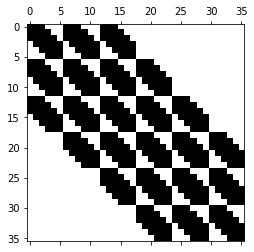

In [21]:
import matplotlib.pyplot as plt 

plt.spy(stiffness)